<a href="https://colab.research.google.com/github/dbeniteze/autoencoder_convolucional/blob/master/mnist_autoencoder_lstm_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install keras==2.3.1

#!apt-get install libgeos-3.5.0
#!apt-get install libgeos-dev
#!pip install https://github.com/matplotlib/basemap/archive/master.zip     #basemap

#!pip install pyproj==1.9.6   #posible arreglo



%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [0]:
# Larger CNN for the MNIST Dataset
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Reshape
from keras.layers import Flatten, BatchNormalization
from keras.layers import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

import os




X_train = np.load("drive/My Drive/temperaturas/temp_tropp.npy", allow_pickle=True)




Using TensorFlow backend.


In [0]:
from keras.layers import  AveragePooling2D
X_train = X_train.reshape((X_train.shape[0], 73, 144, 1)).astype('float32')

1#rango de temperaturas
minimo = np.min(X_train)
maximo = np.max(X_train)

X_train = (X_train - minimo) / (maximo - minimo)


In [0]:
# Larger CNN for the MNIST Dataset
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Reshape
from keras.layers import Flatten, BatchNormalization
from keras.layers import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 1, 28, 28, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 1, 28, 28, 1)).astype('float32')


# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255


epoch = 100

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 30:
        lrate = 0.0005
    if epoch > 70:
        lrate = 0.0003
    return lrate


In [78]:
from keras.layers import Input, LSTM, RepeatVector, ConvLSTM2D
from keras.models import Model


#autoencoder con Conv2DTranspose
input_img = Input(shape=(None, 28, 28, 1))  # adapt this if using `channels_first` image data format
LF = (3,3)
x = ConvLSTM2D(32, kernel_size=LF, strides=2, padding="same", activation='elu', return_sequences=True)(input_img)
x = BatchNormalization()(x)


x = ConvLSTM2D(8, kernel_size=LF, strides=2, padding="same", activation='elu', return_sequences=True)(x)
x = BatchNormalization()(x)

encoded = Reshape((7, 7, 8))(x)

x = Conv2DTranspose(8, kernel_size=LF, strides=2, padding="same", activation='elu')(encoded)
x = BatchNormalization()(x)
x = Conv2DTranspose(1, kernel_size=LF,  strides=2,padding="same", activation='elu')(x)
decoded = Reshape((1, 28, 28, 1))(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, None, 28, 28, 1)   0         
_________________________________________________________________
conv_lst_m2d_46 (ConvLSTM2D) (None, None, 14, 14, 32)  38144     
_________________________________________________________________
batch_normalization_60 (Batc (None, None, 14, 14, 32)  128       
_________________________________________________________________
conv_lst_m2d_47 (ConvLSTM2D) (None, None, 7, 7, 8)     11552     
_________________________________________________________________
batch_normalization_61 (Batc (None, None, 7, 7, 8)     32        
_________________________________________________________________
reshape_26 (Reshape)         (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 14, 14, 8)         584

In [79]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

autoencoder.compile(optimizer=Adam(learning_rate=lr_schedule(epoch)),  loss='mse', metrics=[coeff_determination])

autoencoder.fit(X_train, X_train,
                epochs=epoch,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 12s 203us/step - loss: 0.0459 - coeff_determination: 0.5159 - val_loss: 0.0580 - val_coeff_determination: 0.3956
Epoch 2/100
60000/60000 [==============================] - 10s 170us/step - loss: 0.0096 - coeff_determination: 0.8988 - val_loss: 0.0086 - val_coeff_determination: 0.9099
Epoch 3/100
60000/60000 [==============================] - 10s 169us/step - loss: 0.0067 - coeff_determination: 0.9296 - val_loss: 0.0062 - val_coeff_determination: 0.9344
Epoch 4/100
60000/60000 [==============================] - 10s 171us/step - loss: 0.0054 - coeff_determination: 0.9431 - val_loss: 0.0052 - val_coeff_determination: 0.9450
Epoch 5/100
60000/60000 [==============================] - 10s 171us/step - loss: 0.0046 - coeff_determination: 0.9513 - val_loss: 0.0043 - val_coeff_determination: 0.9552
Epoch 6/100
60000/60000 [==============================] - 10s 172us/step - loss: 0.0040 -

In [0]:
decoded_imgs = autoencoder.predict(X_test)

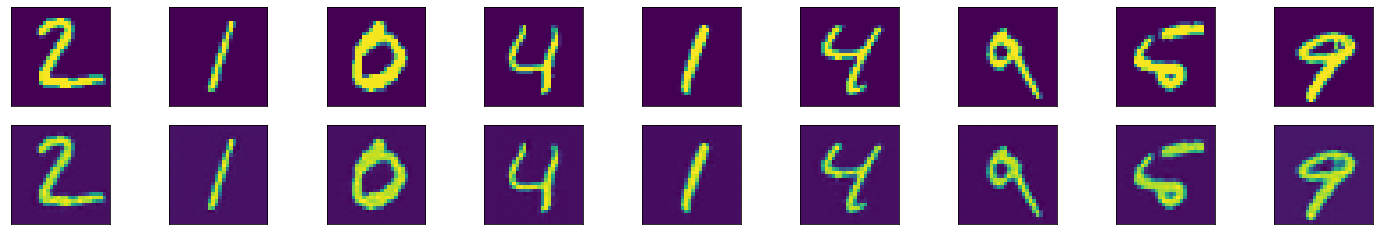

In [109]:
#visualizacion de la decodificacion

X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
decoded_imgs = decoded_imgs.reshape((decoded_imgs.shape[0], 28, 28, 1))

n = 9
plt.figure(figsize=(25, 4))
for i in range(n):
    i = i + 1
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
